<a href="https://colab.research.google.com/github/TalHadad94/Pic2Peak/blob/main/ImageDetectedPic2Peak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import tensorflow as tf
import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# For exporting data.
import pandas as pd
from google.colab import files

In [15]:
print(tf.__version__)

2.8.2


In [16]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256, display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color, font, thickness=4, display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=color)

  # If the total height of the display strings added to the top of the bounding box exceeds the top of the image, stack the strings below the bounding box instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin), (left + text_width, text_bottom)], fill=color)
    draw.text((left + margin, text_bottom - text_height - margin), display_str, fill="black", font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=50, min_score=0.01):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"), int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color, font, display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [17]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" # Import the model from TensorFlow hub


detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [18]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [19]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time:", end_time-start_time)

  image_with_boxes = draw_boxes(img.numpy(), result["detection_boxes"], result["detection_class_entities"], result["detection_scores"], 30)

  display_image(image_with_boxes)
  
  global x
  x = result

In [20]:
def detect_img(image_url):
  start_time = time.time()
  image_path = download_and_resize_image(image_url, 640, 480)
  run_detector(detector, image_path)
  end_time = time.time()
  print("Inference time:", end_time-start_time)

In [21]:
image_urls = [
  "https://upload.wikimedia.org/wikipedia/commons/7/77/Latvian_Forest_Tomes_pagasts%2C_%C4%B6eguma_novads%2C_Latvia.jpg",
  "https://upload.wikimedia.org/wikipedia/commons/7/70/Borgboda2006_web.jpg"]

Image downloaded to /tmp/tmpen_7gl52.jpg.
Found 100 objects.
Inference time: 61.11791944503784
Inference time: 61.727259159088135


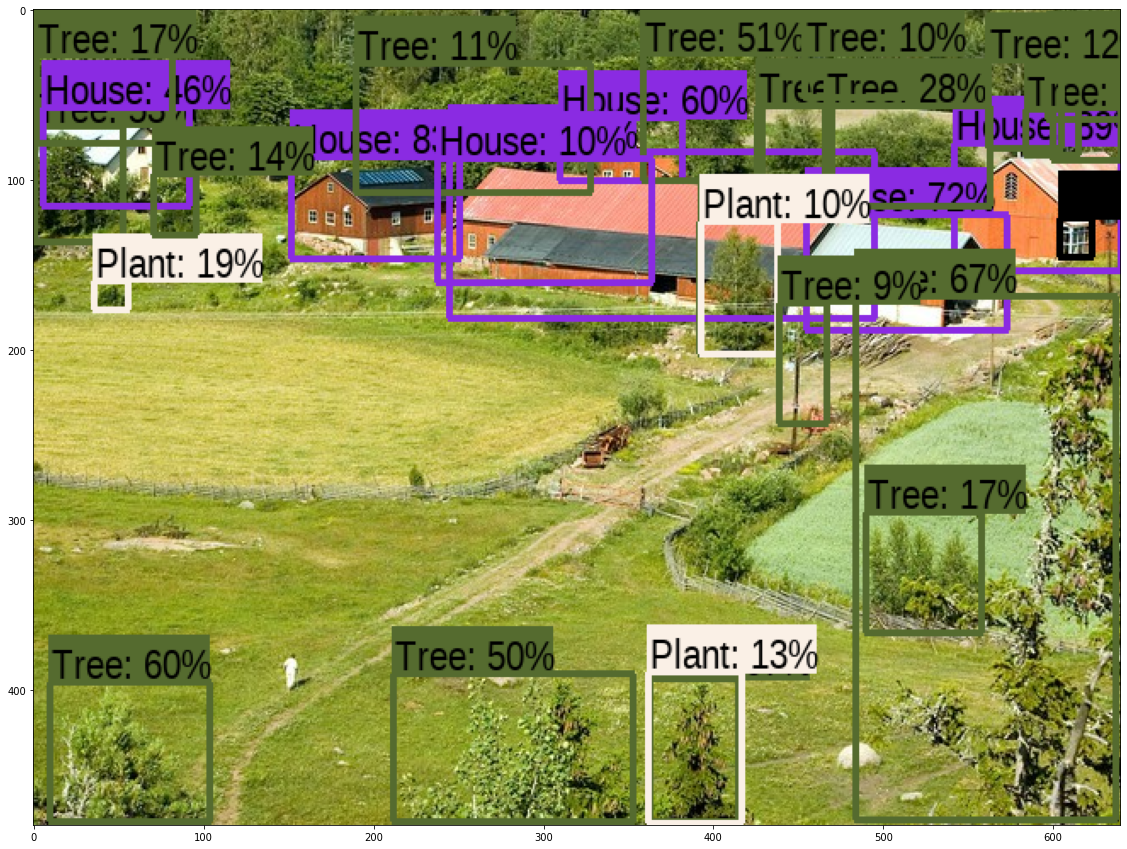

In [22]:
detect_img(image_urls[1])

In [23]:
detectionBoxesLocations = x.get('detection_boxes')

detectionClassEntities = x.get('detection_class_entities')

detectionObjectScores = x.get('detection_scores')

In [24]:
print(detectionBoxesLocations) # [ymax=1-ymax, xmin ,ymin=1-ymin, xmax]

[[1.65698037e-01 8.45551789e-01 3.19309354e-01 1.00000000e+00]
 [1.82678610e-01 2.35949665e-01 3.04349452e-01 3.93127888e-01]
 [1.75521538e-01 3.82706225e-01 3.78556877e-01 7.74904788e-01]
 [2.52228171e-01 7.10877359e-01 3.92434627e-01 8.96115839e-01]
 [3.52157116e-01 7.54845083e-01 9.93596911e-01 9.95554328e-01]
 [8.21506739e-01 5.66841424e-01 9.95822072e-01 6.48720384e-01]
 [8.26566577e-01 1.49013801e-02 9.94901121e-01 1.63827166e-01]
 [1.34599432e-01 4.83204782e-01 2.08366990e-01 5.96964478e-01]
 [1.44992143e-01 1.09778403e-03 2.84835339e-01 8.33950862e-02]
 [2.02666596e-03 5.60611486e-01 2.08672166e-01 6.71829522e-01]
 [8.15645635e-01 3.30750853e-01 9.95580792e-01 5.52212477e-01]
 [2.61380672e-01 6.11611426e-01 4.21120882e-01 6.84778094e-01]
 [1.21762320e-01 8.53130314e-03 2.41492003e-01 1.44734204e-01]
 [1.19300753e-01 6.64260983e-01 2.23124117e-01 7.35315084e-01]
 [2.57448614e-01 9.42471921e-01 3.02759469e-01 9.74313021e-01]
 [1.18922316e-01 7.28082716e-01 2.41048545e-01 8.798675

In [25]:
def center_point(result): # Export to CSV
  detection = {'detection_class_entities':[], 'detection_scores':[], 'detection_boxes':[]}
  detectionBoxesLocations = result['detection_boxes']
  detectionClassEntities = result['detection_class_entities']
  detectionObjectScores = result['detection_scores']
  for i in range(len(detectionBoxesLocations)):
    # [ymax=1-ymax, xmin ,ymin=1-ymin, xmax]
    y = (1-detectionBoxesLocations[i][2])
    x = (detectionBoxesLocations[i][1] + detectionBoxesLocations[i][3]) / 2
    detection['detection_class_entities'].append(detectionClassEntities[i])
    detection['detection_scores'].append(detectionObjectScores[i])
    detection['detection_boxes'].append([x,y])
  df = pd.DataFrame.from_dict(detection) 
  df.to_csv (r'DataTable.csv', index = False, header = True)
  files.download("DataTable.csv")

In [26]:
center_point(x)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>